# IMDB Text Classification Project

In this project I wil classify reviews from the IMDB dataset in HuggingFace. I will do so by using the distillbert-base-uncased from the HuggingFace transfomers library and fine-tuning the pre-trained model on the IMDB dataset.

In [40]:
import os
os.environ["WANDB_DISABLED"] = "true"
from tqdm.notebook import tqdm

In [41]:
import torch, random, numpy as np
seed = 42
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [42]:
from datasets import load_dataset

dataset = load_dataset("imdb")
dataset

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 25000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 25000
    })
    unsupervised: Dataset({
        features: ['text', 'label'],
        num_rows: 50000
    })
})

In [43]:
del dataset['unsupervised']
dataset

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 25000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 25000
    })
})

In [44]:
# Pulling the first example from the train dataset
# label {0: negative, 1: positive}
dataset['train'][0]

{'text': 'I rented I AM CURIOUS-YELLOW from my video store because of all the controversy that surrounded it when it was first released in 1967. I also heard that at first it was seized by U.S. customs if it ever tried to enter this country, therefore being a fan of films considered "controversial" I really had to see this for myself.<br /><br />The plot is centered around a young Swedish drama student named Lena who wants to learn everything she can about life. In particular she wants to focus her attentions to making some sort of documentary on what the average Swede thought about certain political issues such as the Vietnam War and race issues in the United States. In between asking politicians and ordinary denizens of Stockholm about their opinions on politics, she has sex with her drama teacher, classmates, and married men.<br /><br />What kills me about I AM CURIOUS-YELLOW is that 40 years ago, this was considered pornographic. Really, the sex and nudity scenes are few and far be

In [45]:
# Tokenization
from transformers import AutoTokenizer

model_name = "distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_name)

def tokenize_fn(batch):
  return tokenizer(
      batch['text'],    # Tokenize the text column of the batch
      truncation=True,  # Trunkate the output as needed
      max_length=128,
      padding="max_length" # Pad the sentence to max_length as needed
  )

# Tokenize the dataset one batch at a time
# This will add columns to the dataset for the tokenized embeddings
tokenized = dataset.map(tokenize_fn, batched=True)

# We no longer need the text column
tokenized = tokenized.remove_columns(['text'])
tokenized.set_format('torch')

Map:   0%|          | 0/25000 [00:00<?, ? examples/s]

In [46]:
tokenized['train'][0]

{'label': tensor(0),
 'input_ids': tensor([  101,  1045, 12524,  1045,  2572,  8025,  1011,  3756,  2013,  2026,
          2678,  3573,  2138,  1997,  2035,  1996,  6704,  2008,  5129,  2009,
          2043,  2009,  2001,  2034,  2207,  1999,  3476,  1012,  1045,  2036,
          2657,  2008,  2012,  2034,  2009,  2001,  8243,  2011,  1057,  1012,
          1055,  1012,  8205,  2065,  2009,  2412,  2699,  2000,  4607,  2023,
          2406,  1010,  3568,  2108,  1037,  5470,  1997,  3152,  2641,  1000,
          6801,  1000,  1045,  2428,  2018,  2000,  2156,  2023,  2005,  2870,
          1012,  1026,  7987,  1013,  1028,  1026,  7987,  1013,  1028,  1996,
          5436,  2003,  8857,  2105,  1037,  2402,  4467,  3689,  3076,  2315,
         14229,  2040,  4122,  2000,  4553,  2673,  2016,  2064,  2055,  2166,
          1012,  1999,  3327,  2016,  4122,  2000,  3579,  2014,  3086,  2015,
          2000,  2437,  2070,  4066,  1997,  4516,  2006,  2054,  1996,  2779,
         25430, 14

In [47]:
!pip install evaluate -q

In [48]:
from evaluate import load
accuracy = load("accuracy")
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = logits.argmax(axis=-1)
    return accuracy.compute(predictions=preds, references=labels)


In [49]:
from transformers import AutoModelForSequenceClassification, TrainingArguments, Trainer

model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=2)

training_args = TrainingArguments(
    output_dir="./results",
    report_to="none",
    eval_strategy="epoch",
    per_device_train_batch_size=32,
    per_device_eval_batch_size=32,
    num_train_epochs=1,
    logging_steps=100,
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized["train"].shuffle(42).select(range(5000)),
    eval_dataset=tokenized["test"].shuffle(42).select(range(3000)),
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-3471360429.py:15: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


In [50]:
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy
1,0.473300,0.349763,0.844333


TrainOutput(global_step=157, training_loss=0.4322745936691381, metrics={'train_runtime': 62.779, 'train_samples_per_second': 79.644, 'train_steps_per_second': 2.501, 'total_flos': 165584248320000.0, 'train_loss': 0.4322745936691381, 'epoch': 1.0})

In [51]:
trainer.evaluate()

{'eval_loss': 0.34976261854171753,
 'eval_accuracy': 0.8443333333333334,
 'eval_runtime': 9.7389,
 'eval_samples_per_second': 308.042,
 'eval_steps_per_second': 9.652,
 'epoch': 1.0}

In [52]:
preds_output = trainer.predict(tokenized['test'].shuffle(42).select(range(3000)))
y_true = preds_output.label_ids
y_pred = np.argmax(preds_output.predictions, axis=1)

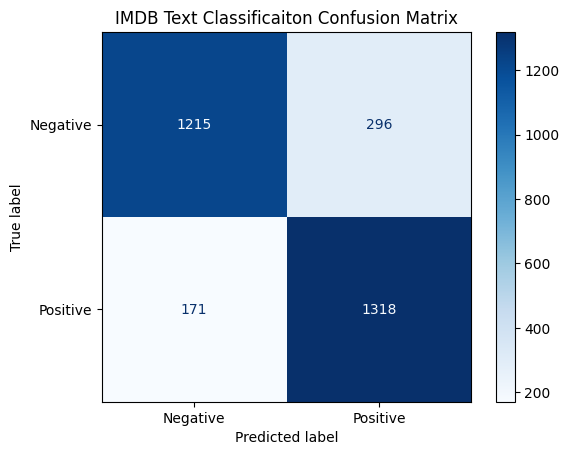

In [53]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(cm, display_labels=["Negative", "Positive"])
disp.plot(cmap="Blues", values_format="d")
plt.title("IMDB Text Classificaiton Confusion Matrix")
plt.savefig("IMDB_CM.png")
plt.show()

In [54]:
from sklearn.metrics import classification_report

print(classification_report(y_true, y_pred, target_names=["Negative", "Positive"]))

              precision    recall  f1-score   support

    Negative       0.88      0.80      0.84      1511
    Positive       0.82      0.89      0.85      1489

    accuracy                           0.84      3000
   macro avg       0.85      0.84      0.84      3000
weighted avg       0.85      0.84      0.84      3000



In [55]:
from random import sample

for idx in sample(range(len(tokenized["test"].shuffle(42).select(range(3000)))), 5):
    text = dataset["test"][idx]["text"]
    true_label = "Positive" if y_true[idx] else "Negative"
    pred_label = "Positive" if y_pred[idx] else "Negative"
    print(f"\n{text[:250]}...")
    print(f"🟢 True: {true_label} | 🔵 Pred: {pred_label}")


Milo is a complete rip off of the 1992 slasher flick Mikey, if you actually check it up both films have the same tagline!But if you want to watch an incredibly funny film with absolutely no plot whatsoever......well then this is the film for you.The ...
🟢 True: Negative | 🔵 Pred: Positive

Well, what can be said about a "horror comedy" that features neither horror nor comedy? There are no characters in the film, but much too many plot lines - all underdeveloped and mostly superfluous.<br /><br />The computer generated creatures look ba...
🟢 True: Positive | 🔵 Pred: Positive

Is it a poorly acted, cliche-ridden pile of trash? Of course. Anyone who doesn't realize that when they pick up the box in the video store probably doesn't have any right judging movies in the first place. Thus, I will now rate the aspects of the fil...
🟢 True: Negative | 🔵 Pred: Negative

The Kite Runner began as one of those "important" films that most people fawn over because they are told that they should if t